**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 57 kB 4.2 MB/s 


In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170498071/170498071 [==============================] - 15s 0us/step


The CIFAR-10 dataset contains 60000 images. The ratio of the data split is 80% training (0.8 x 60000 = 48000 images), 10% validation (0.1 x 60000 = 6000 images) and 10% test (0.1 x 60000 = 6000 images). There are 48000 training images and if in each step of gradient descent, we randomly select 32 examples, and no example appears in more than one batch, it will take 48000/32 = 1500 iterations. As going through the dataset once is one epoch, we need 30 epochs * 1500 iterations = 45000 iterations. Therefore, we need 45000 iterations.


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



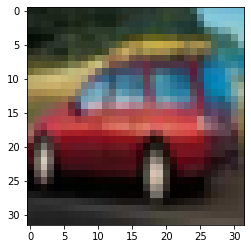

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.

In [ ]:
# Find dimensions of my_image and filter_weights
my_image_shape = np.shape(my_image)
filter_weights_shape = np.shape(filter_weights)
print(my_image_shape)
print(filter_weights_shape)

(1, 3, 32, 32)
(1, 1, 3, 2)


**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  "PUT YOUR CODE HERE"
  my_image_shape = np.shape(my_image)
  initial_filter_weights_shape = np.shape(initial_filter_weights)
  my_conv_output = np.zeros((my_image_shape[0], initial_filter_weights_shape[3], my_image_shape[2], my_image_shape[3])) 
  n_in, n_out, w, h = my_image_shape[1], initial_filter_weights_shape[3], my_image_shape[2], my_image_shape[3]
  for a in range(n_out):
    for b in range(w):
      for c in range(h):
        for d in range(n_in):
          my_conv_output[0][a][b][c] += my_image[0][d][b][c] * initial_filter_weights[0][0][d][a]
  return my_conv_output

print("Filter weights:", filter_weights)
my_conv_output = my_conv_net(my_image, filter_weights)
print("My Conv output:", my_conv_output)
print("My Conv output shape:", np.shape(my_conv_output))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
My Conv output: [[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.73912489
    -0.73746228]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.73105443 -0.74346107
    -0.74085063]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911373 -0.71740329
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253248  0.7320599
     0.72146261]
   [ 0.14844204  0.12636711  0.1275416  ...  0.7793448   0.76264036
     0.75807607]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.77533197]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799

In [ ]:
# This will output true if my own convolution routine returns the same value as Objax's
np.allclose(my_conv_output, Conv2d(my_image))

False

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.1400071 ,  0.35388903]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#PUT YOUR CODE HERE
# Take my rearranged output and feed it into a linear layer of appropriate size
Linear_Layer = objax.nn.Linear(2, 1)
Y1 = Linear_Layer(my_conv_output.mean((2,3)))

# manually implements the linear layer
Y2 = np.dot(my_conv_output.mean((2,3)), Linear_Layer.w.value) + Linear_Layer.b.value

# Print both Y1 and Y2
print("The value of the rearranged output fed into a linear layer is:", Y1[0][0])
print("The value of the manually implemented linear layer is:", Y2[0][0])

The value of the rearranged output fed into a linear layer is: 0.034715444
The value of the manually implemented linear layer is: 0.034715448


The training set is used to determine the ideal weight and bias values for parameters that reduce training error/increase training accuracy. The parameters are then updated in the training routine when the training routine calls the loss function. The output of the optimizer function is then used to determine how the parameters should be modified by using the output of the loss function. The hyperparameters are tuned using the validation set, which is often a smaller dataset than the training set. Values for hyperparameters must be chosen before the training operation is carried out. The model's parameters are not changed while utilising the validation set.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.00
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

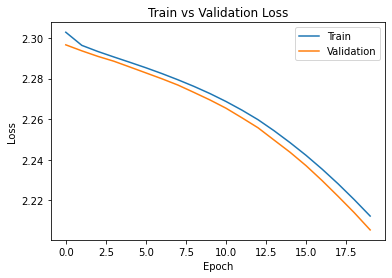

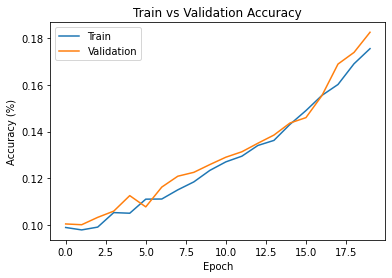

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

Hyperparameters are parameters that the user has specifically established to regulate the learning process of the model. 


Often, we are unaware of the hyperparameters' ideal values that would produce the best model results from the onset. Thus, we must tune the hyperparameters to attain the highest validation accuracy/lowest validation loss. This can be done in our case, via trial and error by testing different hyperparameters values and creating different instantiations of models. Without trying different hyperparameter values, we might be left with a model which isn't accurate and that doesn't offer much insight in terms of predictions when we move onto the testing data which is more practical. 

Q 2.5

The four hyperparameters that I have chosen to tune are: batch size, learning rate, number of output channels in convolution layer 1, and activation function.

With this in mind, two different hyperparameter settings are:

H1 = {16, 0.01, 24, sigmoid}

H2 = {24, 0.003, 16, tanh}

**M1 Model Class with H1 Hyperparameters**

In [ ]:
# H1 = {16, 0.01, 24, sigmoid}
# M1 model class with H1 hyperparameter selection
class M1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2), objax.functional.sigmoid])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 2), objax.functional.sigmoid])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M1()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.12 Validation Accuracy 13.22
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 14.37 Validation Accuracy 14.65
Epoch 0003  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 16.02 Validation Accuracy 15.78
Epoch 0004  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 17.67 Validation Accuracy 15.93
Epoch 0005  Training Loss 2.26 Validation Loss 2.24 Training Accuracy 18.43 Validation Accuracy 15.43
Epoch 0006  Training Loss 2.23 Validation Loss 2.21 Training Accuracy 18.78 Validation Accuracy 18.05
Epoch 0007  Training Loss 2.20 Validation Loss 2.18 Training Accuracy 19.59 Validation Accuracy 17.83
Epoch 0008  Training Loss 2.17 Validation Loss 2.15 Training Accuracy 20.09 Validation Accuracy 19.72
Epoch 0009  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 20.52 Validation Accuracy 20.20
Epoch 0010  Training Loss 2.13 Validation Loss 2.12 Training Accuracy 20.99 Valida

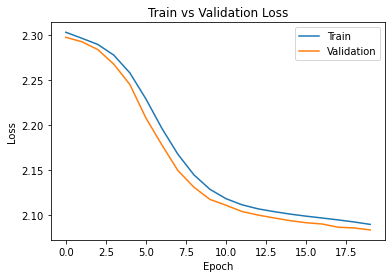

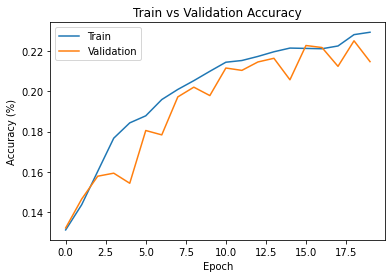

In [ ]:
train()

**M2 Model Class with H2 Hyperparameters**

In [ ]:
# H2 = {24, 0.003, 16, tanh}
# M2 model class with H1 hyperparameter selection
class M2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.tanh])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.tanh])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M2()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 24, LEARNING_RATE = 0.003):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.27 Training Accuracy 12.28 Validation Accuracy 17.72
Epoch 0002  Training Loss 2.26 Validation Loss 2.23 Training Accuracy 18.68 Validation Accuracy 20.77
Epoch 0003  Training Loss 2.21 Validation Loss 2.18 Training Accuracy 21.57 Validation Accuracy 22.30
Epoch 0004  Training Loss 2.15 Validation Loss 2.12 Training Accuracy 22.61 Validation Accuracy 24.12
Epoch 0005  Training Loss 2.11 Validation Loss 2.08 Training Accuracy 23.60 Validation Accuracy 23.18
Epoch 0006  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 24.39 Validation Accuracy 24.32
Epoch 0007  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 24.74 Validation Accuracy 24.73
Epoch 0008  Training Loss 2.03 Validation Loss 2.02 Training Accuracy 25.19 Validation Accuracy 25.00
Epoch 0009  Training Loss 2.02 Validation Loss 2.01 Training Accuracy 25.62 Validation Accuracy 25.38
Epoch 0010  Training Loss 2.01 Validation Loss 2.00 Training Accuracy 25.85 Valida

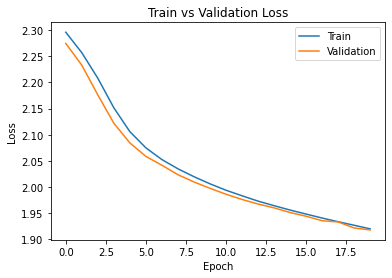

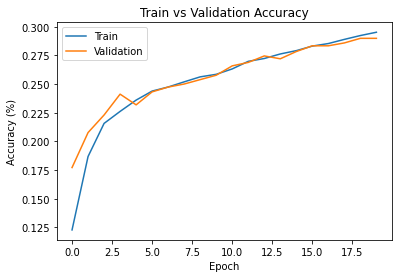

In [ ]:
train()

Report the best validation accuracy as well as the corresponding epoch for which this occurs for the Base Model and your two additional models:

Base Model: 18.27% at Epoch 20

M1: 22.50% at Epoch 19

M2: 28.98% at Epoch 20

The model I would select against test data is M2. M2 has the highest validation accuracy amongst the two other models, which is an indicator that its hyperparameters do the best job in attaining higher accuracy with unseen data. Thus, I expect M2 to perform the best with test data.

In [ ]:
mean_test_loss = float(loss_function(X_test, Y_test)) 
test_prediction = predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Mean Test Loss: %.2f' % (mean_test_loss))
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 2.34
Test set accuracy: 9.97


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [12]:
# I chose to use the Fashion_MNIST dataset
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train = np.expand_dims(X_train, 1)
X_train = X_train / 255.0
X_test = np.expand_dims(X_test, 1)
X_test = X_test / 255.0

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

For the base model, I will use a similar base model the Conv Network I built in Q1


In [13]:
class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = Fashion_MNIST(number_of_channels=1)
#You can examine the architecture of our CNN by calling model.vars()

In [5]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [14]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [15]:
train()

Epoch 0001  Training Loss 1.66 Validation Loss 2.31 Training Accuracy 40.83 Validation Accuracy 40.90
Epoch 0002  Training Loss 1.66 Validation Loss 2.31 Training Accuracy 41.19 Validation Accuracy 41.44
Epoch 0003  Training Loss 1.65 Validation Loss 2.31 Training Accuracy 41.53 Validation Accuracy 40.90


KeyboardInterrupt: ignored

##**Problem 4. Open-Ended Exploration**

See the handout for instructions.